In [130]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

wandb.login(key=os.getenv(key="WANDB_KEY"))

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ubuntu/.netrc


True

In [131]:
data = pd.read_csv("../data/realtor-data.csv")

In [132]:
data.head(2)

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
0,for_sale,105000.0,3.0,2.0,0.12,"Sector Yahuecas Titulo # V84, Adjuntas, PR, 00601",Sector Yahuecas Titulo # V84,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,for_sale,80000.0,4.0,2.0,0.08,"Km 78 9 Carr # 135, Adjuntas, PR, 00601",Km 78 9 Carr # 135,Adjuntas,Puerto Rico,601.0,1527.0,NaN


In [133]:
data.drop_duplicates(inplace=True)
data.reset_index(inplace=True,drop=True)

In [134]:
data.drop(["full_address","street","status","sold_date"],1,inplace=True)

In [135]:
data.head()

,price,bed,bath,acre_lot,city,state,zip_code,house_size
0,105000.0,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0
1,80000.0,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0
2,67000.0,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0
3,145000.0,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0
4,65000.0,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN


In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109497 entries, 0 to 109496
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   price       109479 non-null  float64
 1   bed         92554 non-null   float64
 2   bath        93653 non-null   float64
 3   acre_lot    79676 non-null   float64
 4   city        109475 non-null  object 
 5   state       109497 non-null  object 
 6   zip_code    109465 non-null  float64
 7   house_size  74345 non-null   float64
dtypes: float64(6), object(2)
memory usage: 6.7+ MB


In [137]:
data.state.nunique(),data.zip_code.nunique(),data.city.nunique()

(18, 3118, 2461)

In [138]:
data.dropna(inplace=True)

In [139]:
data.state.nunique(),data.zip_code.nunique(),data.city.nunique()

(14, 2915, 2199)

In [140]:
data.zip_code = data.zip_code.astype(int)

In [141]:
data.head()

,price,bed,bath,acre_lot,city,state,zip_code,house_size
0,105000.0,3.0,2.0,0.12,Adjuntas,Puerto Rico,601,920.0
1,80000.0,4.0,2.0,0.08,Adjuntas,Puerto Rico,601,1527.0
2,67000.0,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795,748.0
3,145000.0,4.0,2.0,0.10,Ponce,Puerto Rico,731,1800.0
5,179000.0,4.0,3.0,0.46,San Sebastian,Puerto Rico,612,2520.0


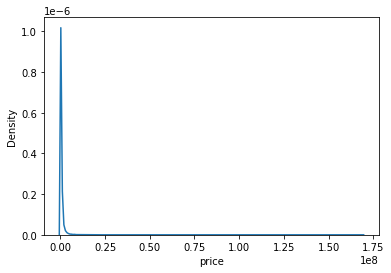

In [142]:
sns.kdeplot("price",data=data);

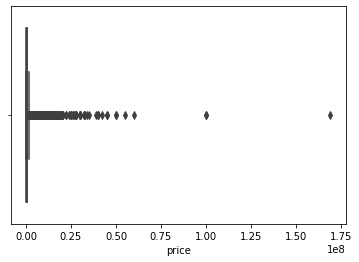

In [143]:
sns.boxplot("price",data=data);

In [144]:
rows_to_drop = data[data["price"]>50000000].index.to_list()

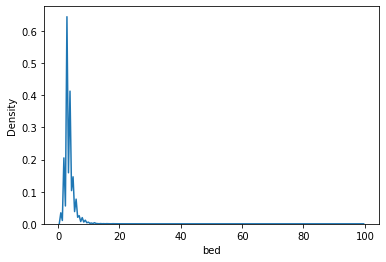

In [145]:
sns.kdeplot(x="bed",data=data);

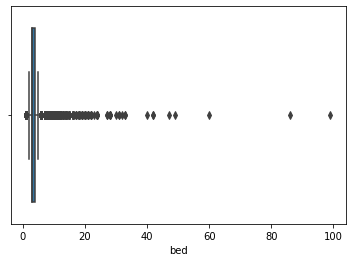

In [146]:
sns.boxplot("bed",data=data);

In [147]:
rows_to_drop.extend(data[data.bed>40].index.to_list())

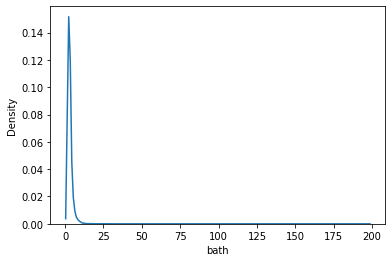

In [148]:
sns.kdeplot(x="bath",data=data);

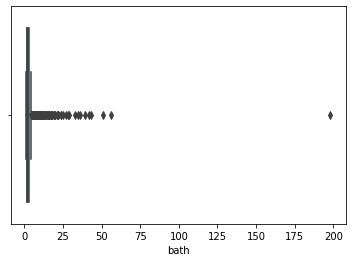

In [149]:
sns.boxplot("bath",data=data);

In [150]:
rows_to_drop.extend(data[data.bath>50].index.to_list())

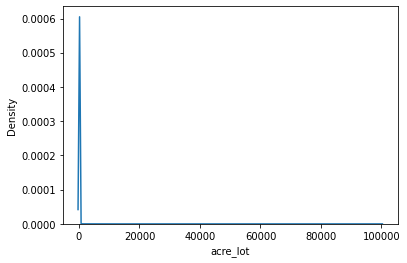

In [151]:
sns.kdeplot(x="acre_lot",data=data);

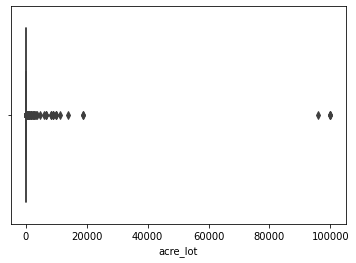

In [152]:
sns.boxplot("acre_lot",data=data);

In [153]:
rows_to_drop.extend(data[data.acre_lot>15000].index.to_list())

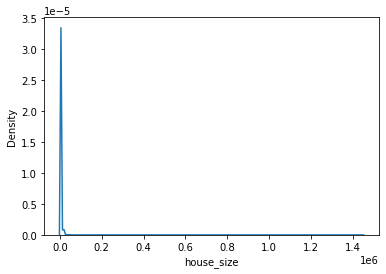

In [154]:
sns.kdeplot(x="house_size",data=data);

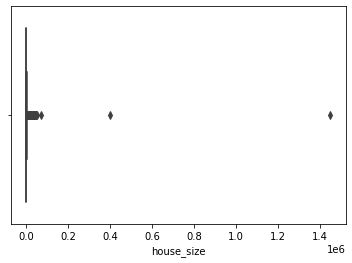

In [155]:
sns.boxplot("house_size",data=data);

In [156]:
rows_to_drop.extend(data[data.house_size>200000].index.to_list())

In [157]:
data.drop(rows_to_drop,0,inplace=True)
data.reset_index(inplace=True,drop=True)

In [158]:
data.city = data.city.apply(lambda x: "_".join(x.lower().split()))
data.state = data.state.apply(lambda x: "_".join(x.lower().split()))

In [159]:
data["location"] = data.state + "-" + data.city
data.drop(["city","state"],1,inplace=True)
data.head()

,price,bed,bath,acre_lot,zip_code,house_size,location
0,105000.0,3.0,2.0,0.12,601,920.0,puerto_rico-adjuntas
1,80000.0,4.0,2.0,0.08,601,1527.0,puerto_rico-adjuntas
2,67000.0,2.0,1.0,0.15,795,748.0,puerto_rico-juana_diaz
3,145000.0,4.0,2.0,0.10,731,1800.0,puerto_rico-ponce
4,179000.0,4.0,3.0,0.46,612,2520.0,puerto_rico-san_sebastian


In [160]:
encoder = LabelEncoder()

data["location"] = encoder.fit_transform(data["location"])

data.head()

,price,bed,bath,acre_lot,zip_code,house_size,location
0,105000.0,3.0,2.0,0.12,601,920.0,2351
1,80000.0,4.0,2.0,0.08,601,1527.0,2351
2,67000.0,2.0,1.0,0.15,795,748.0,2392
3,145000.0,4.0,2.0,0.10,731,1800.0,2412
4,179000.0,4.0,3.0,0.46,612,2520.0,2423


In [161]:
X = data.drop("price",1)
y = data.price

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=45,shuffle=True)

In [163]:
y_test

12961    2000000.0
21630     214900.0
24784     864000.0
2277      175000.0
33991     599900.0
           ...    
48833     249900.0
11204     945000.0
25410     505000.0
21472     304900.0
20026     795000.0
Name: price, Length: 10303, dtype: float64

In [164]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=56),
    "AdaBoost": AdaBoostRegressor(random_state=100),
    "Gradient Boost": GradientBoostingRegressor(random_state=1),
    "XGBoost": XGBRegressor(random_state=103),
    "CatBoost": CatBoostRegressor(random_state=200,verbose=False),
    "Lightgbm": LGBMRegressor(random_state=2022)
}

for name, model in models.items():
    wandb.init(project="capstone-mlops", entity="heisguyy",name=name,tags=["baseline"])
    model.fit(X_train,y_train)
    y_preds = model.predict(X_test)
    error = mean_squared_error(y_test,y_preds,squared=False)
    wandb.summary["error"] = error
    wandb.finish()

error,1372707.86956


error,1049357.36064


error,1457986.56524


error,1094319.13936


error,906895.27558


error,872799.99544


error,900580.18884


In [165]:
data.to_csv("../data/clean.csv",index=False)